In [1]:
using FFTW, LinearAlgebra
function cubiccos(c1,c2,c3) # Input: Cosine coefficients
    m = length(c1)
    a1 = [reverse(c1[2:end]); c1] # Fourier coefficient
    a2 = [reverse(c2[2:end]); c2] # Fourier coefficient
    a3 = [reverse(c3[2:end]); c3] # Fourier coefficient
    N = 2m # (p-1)m
    ta1 = [zeros(N,1);a1;zeros(N,1)] # 1. Padding zeros
    ta2 = [zeros(N,1);a2;zeros(N,1)]
    ta3 = [zeros(N,1);a3;zeros(N,1)]
    tb1 = ifft(ifftshift(ta1)) # 2. IFFT of ta
    tb2 = ifft(ifftshift(ta2))
    tb3 = ifft(ifftshift(ta3))
    tb³ = tb1 .* tb2 .* tb3    # 3. tb *^ tb *^ tb
    c³ = real(fftshift(fft(tb³))*(6m-1)^2) # 4. FFT of tb_cubic
    return c³[N+m:N+m+3*(m-1)] # return Cosine coefficients
end

function powerconvcos(c,p)
    m = length(c)
    a = [reverse(c[2:end]); c]# Fourier coefficient
    N = (p-1)*m
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = real(fftshift(fft(tbᵖ))*(2.0*p*m-1)^(p-1)) # 4. FFT of tb2
    return cᵖ[N+m:N+m+p*(m-1)]# return Chebyshev coefficients
end

powerconvcos (generic function with 1 method)

In [3]:
function F_equilibrium(c,λ) # Input: cosine Fourier
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    c3 = cubiccos(c,c,c)
    μ = λ .- (1 .- k.^2).^2
    return μ .* c - c3[1:N+1]
end

function DF_equilibrium(c,λ)
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    DF_linear = λ .- (1 .- k.^2).^2
    DF_nonlinear = zeros(N+1,N+1)
    c2 = powerconvcos(c,2)
    DF_nonlinear[:,1] = -3 * c2[k .+ 1]
    for j = 1:N
        DF_nonlinear[:,j+1] = -3 * (c2[abs.(k .- j) .+ 1] + c2[abs.(k .+ j) .+ 1])
    end
    return diagm(DF_linear) + DF_nonlinear
end

# function finite_diff_DF(c,λ)
# h=1e-8
# m=length(c)
# E=Matrix{Float64}(I,m,m)
# Df=zeros(m,m)
# for j=1:m
#     ch = c .+ h*E[:,j]
#     Df[:,j] = (F_equilibrium(ch,λ) -  F_equilibrium(c,λ))/h
# end
#     return Df
# end

DF_equilibrium (generic function with 1 method)

In [6]:
# c = ones(10)
# @show F_equilibrium(c,1.0)
# DF = DF_equilibrium(c,1.0)
# DF_finite = finite_diff_DF(c,1.0)
# DF - DF_finite

In [11]:
using LinearAlgebra

function newton_F(c,λ)
    # Newton iteration
    num_itr = 0; p = 1; tol = 5e-10
    Fc = F_equilibrium(c,λ)
    println("Before iteration: $(norm(Fc,p))")
    while num_itr ≤ 100
        DF = DF_equilibrium(c,λ)
        c = c - DF\Fc
        num_itr += 1
        Fc = F_equilibrium(c,λ)
        println("After $(num_itr) iteration: $(norm(Fc,p))")
        if norm(Fc,p) < tol
            break
        end
    end
    return c
end

newton_F (generic function with 1 method)

In [86]:
N=10
c0 = 100*randn(N)./(1:N).^2
# c0 = 100*randn(10)./(1:10).^2
λ = 1.0
# λ = 150.0
c0 = newton_F(c0,λ)
# for λ = 1.0:0.1:2.5
#     c0 = newton_F(c0,λ)
# end
c̄ = c0

Before iteration: 107622.83757508405
After 1 iteration: 29775.296354129892
After 2 iteration: 8973.793668323453
After 3 iteration: 2673.2378023626375
After 4 iteration: 790.9968458407639
After 5 iteration: 234.52096130290658
After 6 iteration: 68.73484432812533
After 7 iteration: 18.98072782339959
After 8 iteration: 4.810245811429733
After 9 iteration: 1.1204468684863158
After 10 iteration: 0.2123755192449122
After 11 iteration: 0.019167817859624407
After 12 iteration: 0.00022194661835366124
After 13 iteration: 3.092143690470534e-8
After 14 iteration: 8.501741203936008e-16


10-element Vector{Float64}:
  1.568099091972657e-16
 -0.578828396578559
 -1.0518575801552377e-17
  0.002983176595427379
 -3.3664222927293084e-19
 -5.169797543765678e-6
 -2.705163973953895e-20
  8.93546172580073e-9
 -8.002771067566005e-21
 -1.3896587701967077e-11

In [69]:
c̄
 # -3.174206918025166e-17
 #  0.578828396578559
 #  7.64926383709692e-18
 # -0.00298317659542738
 #  3.307686656721567e-19
 #  5.16979754376579e-6
 #  3.110736687494745e-20
 # -8.935461725764542e-9
 # -9.5954875244702e-21
 #  1.3896587715387632e-11

10-element Vector{Float64}:
 -4.738214976520205e-15
 -0.578828396578564
 -1.040185226372787e-18
  0.002983176595427417
  1.3969739962109192e-19
 -5.1697975437658915e-6
  7.467852396133932e-21
  8.93546172576071e-9
 -2.1134325204029923e-20
 -1.3896587708407554e-11

In [85]:
using Plots
function plot_cos(a)
    cₖ = [reverse(a[2:end]); a]
    N = Int((length(cₖ)+1)/2)# 2N-1
    n_pad = 200
    cₖ_pad = [zeros(n_pad);cₖ;zeros(n_pad)]
    N_pad = N + n_pad
    h_pad = 2.0π/(2N_pad-1)
    xⱼ_pad = h_pad*(0:(2N_pad-2))
    
    fᴺⱼ_pad = real((2N_pad-1)*ifft(ifftshift(cₖ_pad)))
    # plot(xⱼ_pad[N_pad:end], fᴺⱼ_pad[N_pad:end], legend=false, title = "Plot cosine Fourier series",
    plot(xⱼ_pad[1:N_pad-1], fᴺⱼ_pad[1:N_pad-1], legend=false, title = "Plot cosine Fourier series",
        line=2,
        xlabel = "\$x\$",
        ylabel = "\$u(x)\$",)
end

plot_cos (generic function with 1 method)

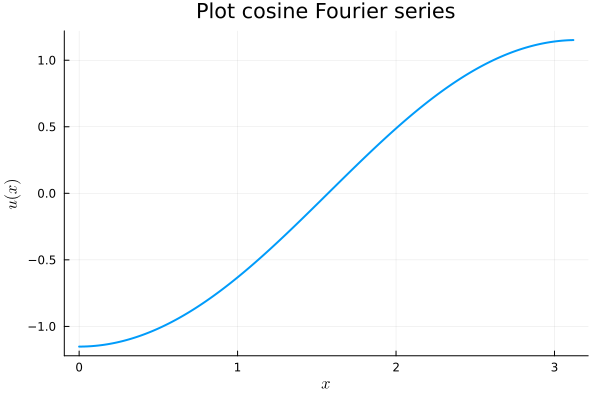

In [90]:
# c̄ = [0;0;.5;zeros(N-2)]
plot_cos(c̄)
# savefig("steadystateSH.pdf")

In [61]:
# solve Swift-Hohenberg
function F!(F, u, λ)
    ∂² = project(Derivative(2), space(u), space(u))
    project!(F, λ * u - (I + ∂²)^2 * u - u^3)
    return F
end

function DF!(DF, u, λ)
    ∂² = project(Derivative(2), space(u), space(u))
    add!(DF, λ * I - (I + ∂²)^2, Multiplication(-3u^2))
    return DF
end


DF! (generic function with 1 method)

In [138]:
using RadiiPolynomial

N = 50
λ = 5.0
# u = Sequence(CosFourier(N, 1.0), rand(N+1))
u = Sequence(CosFourier(N, 1.0), 100*randn(N+1)./(1:N+1).^2)
# 100*randn(N)./(1:N).^2

newton!((F, DF, u) -> (F!(F, u, λ), DF!(DF, u, λ)), u, maxiter = 100)

Newton's method: Inf-norm, tol = 1.0e-12, maxiter = 100
      iteration        |F(x)|
-------------------------------------
          0          6.2071e+05        |DF(x)\F(x)| = 1.0347e+01
          1          2.3245e+04        |DF(x)\F(x)| = 6.4333e+00
          2          6.9537e+03        |DF(x)\F(x)| = 5.8579e+00
          3          2.0621e+03        |DF(x)\F(x)| = 3.9399e+00
          4          6.0940e+02        |DF(x)\F(x)| = 2.5654e+00
          5          1.7796e+02        |DF(x)\F(x)| = 1.5850e+00
          6          5.0681e+01        |DF(x)\F(x)| = 9.2505e-01
          7          1.3580e+01        |DF(x)\F(x)| = 4.7147e-01
          8          3.1217e+00        |DF(x)\F(x)| = 2.0745e-01
          9          5.1937e-01        |DF(x)\F(x)| = 7.1379e-02
         10          3.7466e-02        |DF(x)\F(x)| = 6.0712e-03
         11          2.5394e-04        |DF(x)\F(x)| = 4.2383e-05
         12          1.2163e-08        |DF(x)\F(x)| = 2.0481e-09
         13          5.3291e-15

(Sequence(CosFourier(50, 1.0), [-4.761921208561089e-18, 1.30640723781266, 1.462389562135055e-18, -0.03221961862009861, -1.748598584184726e-20, 0.0002768370020165041, -1.2633390302593387e-22, -2.345421425959903e-6, 4.529261453405449e-24, 1.787277614052683e-8  …  1.5542967652424005e-43, 2.6385685431149346e-59, -9.548405757420221e-46, -3.0806055006479638e-61, 5.853113795907007e-48, 2.845684412776636e-63, -3.580834466634983e-50, -2.235818639173217e-65, 2.186726134677528e-52, 1.4989992924668903e-67]), true)

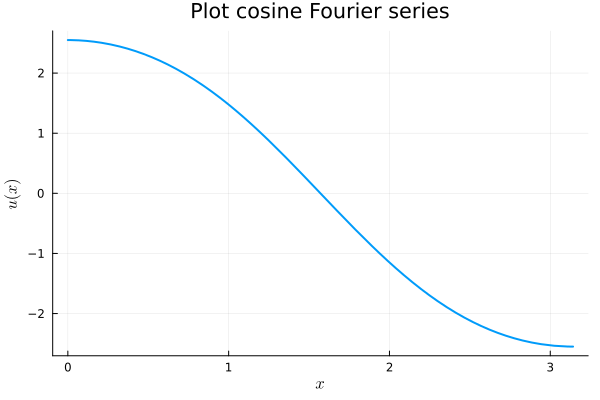

In [141]:
# u = Sequence(CosFourier(N, 1.0), [0;.5;zeros(N-1)])
plot(x -> u(x),0 ,π, legend=false, title = "Plot cosine Fourier series",
        line=2,
        xlabel = "\$x\$",
        ylabel = "\$u(x)\$",)
# savefig("steadystate2SH.pdf")

# $A^\dagger$, $A$の計算

In [9]:
DF_c̄ = DF_equilibrium(c̄,λ) # DF^{(m)}(c̄^{(m)})
Am = inv(DF_c̄)

10×10 Matrix{Float64}:
 -0.551788     -8.08011e-12   0.109834     …  -3.01066e-9    2.15923e-20
 -4.04005e-12  -0.502471      9.35762e-15      2.23516e-20  -1.06696e-10
  0.0549168     9.35762e-15  -0.110975         2.87232e-9   -1.59357e-21
  7.55114e-14   0.00760904   -2.77298e-14     -4.1726e-21    1.64203e-10
 -0.000266976   3.30025e-16   0.000493503     -1.24391e-8   -3.05384e-22
 -2.18306e-16  -2.20857e-5    7.89837e-17  …   4.75227e-20  -2.91676e-9
  6.99984e-7   -7.49815e-19  -1.34061e-6       2.04389e-7    1.27707e-20
  5.29974e-19   5.33732e-8   -1.83839e-19     -1.76249e-18   6.7423e-8
 -1.50533e-9    2.23516e-20   2.87232e-9      -0.000251889  -6.35007e-19
  1.07961e-20  -1.06696e-10  -1.59357e-21     -6.35007e-19  -0.000156225

# $Y_0$評価

In [10]:
using LinearAlgebra

function wnorm(a,ν)
    m = length(a)
    nu_power = [1; 2*ν.^(1:m-1)]
    return sum(abs.(a).*nu_power)
end

function wnorm_mat(M,ν)
    m = size(M,2)
    nu_power = [1; 2*ν.^(1:m-1)]
    return maximum(sum(abs.(M) .* nu_power, dims=1)./nu_power')
end

wnorm_mat (generic function with 1 method)

In [11]:
ν = 1.2
m = length(c̄)
function F_ext(c,λ) # Input: cosine Fourier
    N = length(c)-1 # maximum wave (N = m-1)
    c_ext = zeros(3N+1)
    c_ext[1:N+1] = c
    k = (0:3N)
    c3 = cubiccos(c,c,c)
    return λ*c_ext - (1 .- k.^2).^2 .* c_ext - c3
    # -k.^2*omega^2 .* a + a2[N+1:end]
end
f_c̄ = F_ext(c̄,λ)
fm = f_c̄[1:m]

k = m:3*(m-1)
μ = λ .-  (1 .- k.^2).^2

f_c̄[1:m] .= 0
f_c̄[m+1:end] = f_c̄[m+1:end] ./ μ

Y0 = wnorm(Am*fm,ν) + wnorm(f_c̄,ν)

1.6159171736423993e-11

# $Z_0$評価

In [12]:
Z0 = wnorm_mat(I - Am * DF_c̄,ν)

3.037464169404665e-16

# $Z_1$評価

In [27]:
Ψ = zeros(m)
c2_ext = zeros(6(m-1))
c2 = powerconvcos(c̄,2)
c2_ext[1:2(m-1)+1] = c2


for k = 0:m-1
    tmp = 0
    for k1 = m:k+2(m-1)
        # @show c2_ext[abs(k-k1)+1] + c2_ext[abs(k+k1)+1]
        tmp = max(tmp, abs(c2_ext[abs(k-k1)+1] + c2_ext[abs(k+k1)+1])/(2ν^(k1)))
    end
    Ψ[k+1] = tmp
end
μₘ = λ .- (1 .- m^2)^2
Z1 = wnorm(3*Am*Ψ,ν) + 3*wnorm(c2,ν)/abs(μₘ)

0.0007899889913785585

# $Z_2$評価

In [30]:
function Mopnorm(M,ν,δ)
    return max(wnorm_mat(M,ν),δ)
end
A_opnorm = Mopnorm(Am,ν,1/abs(μₘ))
c1 = wnorm(c̄,ν)

Z2(r) = 3*A_opnorm*(r+2*c1)

Z2 (generic function with 1 method)

# Radii-polynomial

In [35]:
c1

1.3995238025176022

In [36]:
p(r) = Z2(r)*r^2 - (1-Z0-Z1)*r + Y0

p (generic function with 1 method)

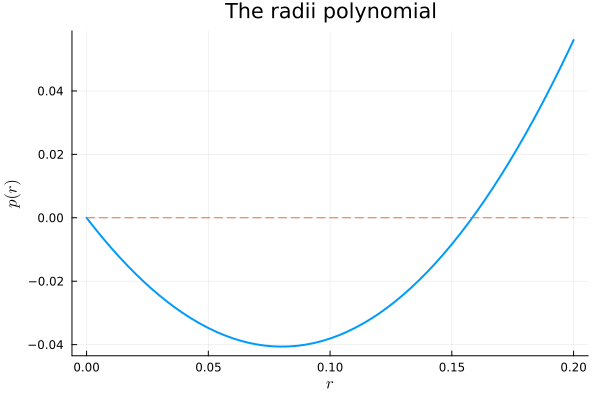

In [46]:
plot(p,0,0.2,
    line = 2,
    legend = false,
    title = "The radii polynomial",
    xlabel = "\$r\$",
    ylabel = "\$p(r)\$",
)
plot!(x->0,0,0.2,linestyle=:dash)